In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [5]:
print(tf.__version__)

2.8.0


In [6]:
data = pd.read_csv("/content/drive/MyDrive/data/Mobile_up.csv", encoding='latin1')
data.head()

,Unnamed: 0,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label
0,0,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Just excellent,5,excellent,1.0,Positive,1
1,1,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1
2,2,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1
3,4,Apple iPhone 12 (128GB) - Blue,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1
4,5,Apple iPhone 12 (128GB) - Blue,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1


In [7]:
mydata = data
mydata.head()

,Unnamed: 0,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label
0,0,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Just excellent,5,excellent,1.0,Positive,1
1,1,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1
2,2,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1
3,4,Apple iPhone 12 (128GB) - Blue,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1
4,5,Apple iPhone 12 (128GB) - Blue,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1


In [8]:
mydata.shape

(99442, 9)

In [9]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99442 entries, 0 to 99441
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    99442 non-null  int64  
 1   Product Name  99442 non-null  object 
 2   Brand         99442 non-null  object 
 3   Reviews       99442 non-null  object 
 4   Rating        99442 non-null  int64  
 5   Lemma         99442 non-null  object 
 6   Polarity      99442 non-null  float64
 7   Analysis      99442 non-null  object 
 8   Label         99442 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 6.8+ MB


#Data Preprocessing

###Missing Values Imputation

In [10]:
# Let's see which number of rows consist missing values for 'Reviews' column 
mydata[mydata['Reviews'].isnull()]

,Unnamed: 0,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label


### Cleaning Text

In [11]:
# Define a function to clean the text
import re
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

# Cleaning the text in the review column
mydata['Cleaned Reviews'] = mydata['Reviews'].apply(clean)
mydata.head()

,Unnamed: 0,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label,Cleaned Reviews
0,0,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Just excellent,5,excellent,1.0,Positive,1,Just excellent
1,1,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1,Currently the best phone Apple makes
2,2,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1,This took one of my kidneys and a testicle But...
3,4,Apple iPhone 12 (128GB) - Blue,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1,Best Premium Smartphone in all aspects
4,5,Apple iPhone 12 (128GB) - Blue,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1,Best iPhone


### Tokenize, Stop-words, pos 

In [12]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
        
    return newlist

mydata['POS tagged'] = mydata['Cleaned Reviews'].apply(token_stop_pos)
mydata.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,Unnamed: 0,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label,Cleaned Reviews,POS tagged
0,0,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Just excellent,5,excellent,1.0,Positive,1,Just excellent,"[(excellent, n)]"
1,1,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1,Currently the best phone Apple makes,"[(Currently, r), (best, a), (phone, n), (Apple..."
2,2,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1,This took one of my kidneys and a testicle But...,"[(took, v), (one, None), (kidneys, n), (testic..."
3,4,Apple iPhone 12 (128GB) - Blue,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1,Best Premium Smartphone in all aspects,"[(Best, n), (Premium, n), (Smartphone, n), (as..."
4,5,Apple iPhone 12 (128GB) - Blue,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1,Best iPhone,"[(Best, n), (iPhone, n)]"


# Obtaining the stem words – Lemmatization

In [13]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

mydata['Lemma'] = mydata['POS tagged'].apply(lemmatize)
mydata.head()

,Unnamed: 0,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label,Cleaned Reviews,POS tagged
0,0,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Just excellent,5,excellent,1.0,Positive,1,Just excellent,"[(excellent, n)]"
1,1,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1,Currently the best phone Apple makes,"[(Currently, r), (best, a), (phone, n), (Apple..."
2,2,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1,This took one of my kidneys and a testicle But...,"[(took, v), (one, None), (kidneys, n), (testic..."
3,4,Apple iPhone 12 (128GB) - Blue,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1,Best Premium Smartphone in all aspects,"[(Best, n), (Premium, n), (Smartphone, n), (as..."
4,5,Apple iPhone 12 (128GB) - Blue,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1,Best iPhone,"[(Best, n), (iPhone, n)]"


In [14]:
mydata[['Reviews','Lemma']]

,Reviews,Lemma
0,Just excellent,excellent
1,Currently the best phone Apple makes,Currently best phone Apple make
2,This took one of my kidneys and a testicle. Bu...,take one kidney testicle worth
3,Best Premium Smartphone in all aspects,Best Premium Smartphone aspect
4,Best iPhone,Best iPhone
...,...,...
99437,Stopped turning on within 3 days. With no warr...,Stopped turn within day warranty royally f e...
99438,Came as expected,Came expect
99439,Bad. Azz. Phone.,Bad Azz Phone
99440,"Love the phone, great screen, fast, slim but d...",Love phone great screen fast slim dislike Mo...


### Look at the Lemma text using wordcloud 

In [15]:
! pip install wordcloud

In [16]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [17]:
# Create a new data frame 'reviewss' to perform exploratory data analysis on that
reviewss = mydata
# dropping null values
reviewss.dropna(inplace = True)

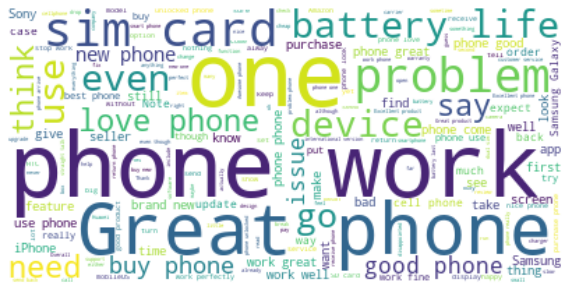

In [18]:
# wordcloud function's need to be a single string of text
# concatenating all reviews in a single string
reviewss_str = reviewss.Lemma.str.cat()
wordcloud = WordCloud(background_color='white').generate(reviewss_str)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

# Sentiment Analysis using TextBlob:

In [19]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

i = -1
# function to analyze the reviews
def analysis(score):
    global i
    i = i+1
    if score > 0 and fin_data['Rating'][i] >3:
      return 'Positive'
    elif score == 0 and fin_data['Rating'][i] == 3:
      return 'Neutral'             
    else:
      return 'Negative'


        

In [20]:
fin_data = pd.DataFrame(mydata[['Brand','Reviews','Rating','Lemma']])

In [21]:
# fin_data['Subjectivity'] = fin_data['Lemma'].apply(getSubjectivity) 
fin_data['Polarity'] = fin_data['Lemma'].apply(getPolarity) 
fin_data['Analysis'] = fin_data['Polarity'].apply(analysis)
fin_data.head()

,Brand,Reviews,Rating,Lemma,Polarity,Analysis
0,Apple,Just excellent,5,excellent,1.0,Positive
1,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive
2,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive
3,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive
4,Apple,Best iPhone,5,Best iPhone,1.0,Positive


Removing Neutral from Label

In [22]:
fin_data = fin_data[fin_data.Analysis != 'Neutral']

### Count the number of positive, negative, neutral reviews. 

In [23]:
tb_counts = fin_data.Analysis.value_counts()
tb_counts

Positive    49721
Negative    49721
Name: Analysis, dtype: int64

In [24]:
tb_apple_counts = fin_data[(fin_data.Brand)=='Apple'].Analysis.value_counts()
tb_apple_counts

Positive    19948
Negative    18590
Name: Analysis, dtype: int64

In [25]:
tb_samsung_counts = fin_data[(fin_data.Brand)=='Samsung'].Analysis.value_counts()
tb_samsung_counts

Negative    20617
Positive    18156
Name: Analysis, dtype: int64

In [26]:
tb_htc_counts = fin_data[(fin_data.Brand)=='HTC'].Analysis.value_counts()
tb_htc_counts

Negative    3646
Positive    2773
Name: Analysis, dtype: int64

In [27]:
tb_sony_counts = fin_data[(fin_data.Brand)=='Sony'].Analysis.value_counts()
tb_sony_counts

Positive    5360
Negative    4318
Name: Analysis, dtype: int64

In [28]:
fin_data[(fin_data.Brand)=='Huawei'].Analysis.value_counts()

Positive    2933
Negative    1363
Name: Analysis, dtype: int64

In [29]:
fin_data[(fin_data.Brand)=='Asus'].Analysis.value_counts()

Negative    914
Positive    452
Name: Analysis, dtype: int64

###Labeling Reviews

In [30]:
labels = []
for cell in fin_data['Analysis']:
  if cell == 'Positive':
    labels.append('1')    
  else:
    labels.append('0')   

fin_data['Label'] = labels

In [31]:
data = pd.DataFrame(fin_data[['Brand','Lemma','Label']])

In [32]:
def example_complain(index):
    example = data[data.index == index][['Lemma', 'Brand']].values[0]
    if len(example) > 0:
        print(example[0])
        print()
        print('Category:', example[1])

In [33]:
example_complain(10)

  Good phone super camara

Category: Apple


In [34]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['Lemma'] = data['Lemma'].apply(clean_text)

In [35]:
example_complain(10)

good phone super camara

Category: Apple


In [36]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Lemma'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22873 unique tokens.


In [37]:
X = tokenizer.texts_to_sequences(data['Lemma'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (99442, 250)


In [38]:
Y = pd.get_dummies(data['Label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (99442, 2)


In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(79553, 250) (79553, 2)
(19889, 250) (19889, 2)


In [40]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=64,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0, verbose=0, 
    mode="auto",
    baseline=None,
    restore_best_weights=False)])

Epoch 1/5
1119/1119 [==============================] - 1010s 898ms/step - loss: 0.2498 - accuracy: 0.9013 - val_loss: 0.1752 - val_accuracy: 0.9353
Epoch 2/5
1119/1119 [==============================] - 944s 844ms/step - loss: 0.1481 - accuracy: 0.9464 - val_loss: 0.1484 - val_accuracy: 0.9467
Epoch 3/5
1119/1119 [==============================] - 946s 845ms/step - loss: 0.1190 - accuracy: 0.9576 - val_loss: 0.1433 - val_accuracy: 0.9498
Epoch 4/5
1119/1119 [==============================] - 948s 848ms/step - loss: 0.1002 - accuracy: 0.9647 - val_loss: 0.1439 - val_accuracy: 0.9520
Epoch 5/5
1119/1119 [==============================] - 941s 841ms/step - loss: 0.0871 - accuracy: 0.9703 - val_loss: 0.1510 - val_accuracy: 0.9549


In [42]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

622/622 [==============================] - 39s 63ms/step - loss: 0.1620 - accuracy: 0.9515
Test set
  Loss: 0.162
  Accuracy: 0.952


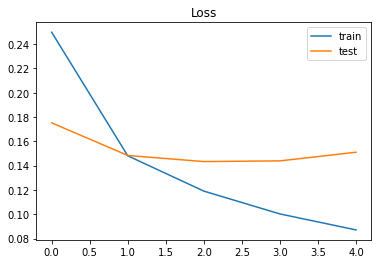

In [43]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [44]:
new_complaint = ['Samsung s22 has bad quality']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['0', '1']
print(pred, labels[np.argmax(pred)])

[[9.9972659e-01 2.7338834e-04]] 0
